In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from tqdm import tqdm, tqdm_notebook
from itertools import combinations
from scipy.sparse.csr import csr_matrix
import dgl
from dgl import DGLGraph
from dgl.data.utils import save_graphs, load_graphs

Using backend: pytorch


In [6]:
import torch
import pickle

In [2]:
label_set = pd.read_csv("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/input/sample_submission.csv", header=0, index_col=0).columns.tolist()
print(label_set)

['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bicycle_bell', 'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering', 'Chewing_and_mastication', 'Child_speech_and_kid_speaking', 'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock', 'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone', 'Mechanical_fan', 'Meow', 'Microwave_oven', 'Motorcycle', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Raindrop', 'Run', 'Scissors', 'Screaming', 'Shatter', 

In [3]:
label2index = {v:i for i, v in enumerate(label_set)}

In [4]:
def preprocess_aname(name0):
    return name0.replace(", ", " and ").replace(" and and ", " and ").replace(" ", "_")

In [5]:
alabel2index = {}
aid2index = {}
audioset = {}
with open("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/input/ontology.json") as f:
    json0 = json.load(f)
    for i, record in enumerate(json0):
        id0, name0 = record["id"], record["name"]
        name0 = preprocess_aname(name0)
        audioset[id0] = record
        alabel2index[name0] = i
        aid2index[id0] = i
print(len(audioset))
# indices of labels in the whole of audioset
class_indices = [alabel2index[label] for label in label_set]
print(class_indices)

632
[416, 238, 162, 77, 86, 190, 161, 437, 232, 65, 383, 149, 376, 76, 61, 5, 512, 130, 230, 70, 453, 359, 146, 79, 426, 429, 428, 427, 518, 160, 67, 35, 4, 522, 69, 431, 49, 204, 200, 357, 237, 194, 96, 445, 423, 34, 3, 203, 480, 95, 432, 388, 483, 94, 377, 350, 57, 448, 16, 513, 28, 436, 405, 422, 54, 425, 352, 165, 424, 476, 439, 389, 520, 59, 435, 355, 17, 454, 13, 443]


In [7]:
def to_binary(mat, threshold=0.4):
    # binarize according to conditional probability > threshold
    # ref: Multi-Label Image Recognition with Graph Convolutional Networks
    cond_prob = mat / mat.sum(axis=1, keepdims=True)
    return (cond_prob >= threshold).astype(int)

In [8]:
extracted_audioset_rels_sel = json.load(open("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/reorg_code/extracted_audioset_rels_sel.json", encoding="utf-8"))
len(extracted_audioset_rels_sel)

6269

In [9]:
N_nodes = len(audioset)

In [10]:
extracted_audioset_rels_v2 = json.load(open("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/reorg_code/extracted_audioset_rels_v2.json", encoding="utf-8"))
len(extracted_audioset_rels_v2)

1682

In [11]:
extracted_audioset_rels_v3 = json.load(open("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/reorg_code/extracted_audioset_rels_v3.json", encoding="utf-8"))
len(extracted_audioset_rels_v3)

32086

## type 1 graph: 80 nodes

nodes == labels

In [7]:
train_curated = pd.read_csv("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/input/train_curated.csv")
train_noisy = pd.read_csv("/home/zhiling/py3_workspace/freesound-audio-tagging-2019/input/train_noisy.csv")

155


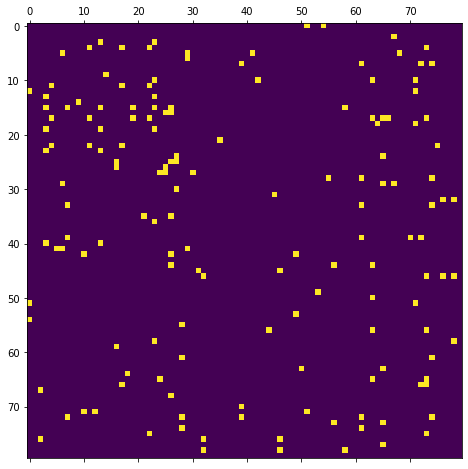

In [8]:
N_labels = len(label2index)
adj_curated = np.zeros((N_labels, N_labels))
for labels0 in train_curated["labels"]:
    labels0 = labels0.split(",")
    if len(labels0) > 1:
        for a, b in combinations(labels0, 2):
            ida, idb = label2index[a], label2index[b]
            adj_curated[ida, idb] += 1
            adj_curated[idb, ida] += 1
adj_curated_b = to_binary(adj_curated, 0.1)
fig = plt.figure(figsize=(8,8))
plt.matshow(adj_curated_b, fignum=0)
print(adj_curated_b.sum())
plt.show()

In [9]:
dgl_curated_b = dgl.from_scipy(csr_matrix(adj_curated_b))
dgl_curated_b = dgl_curated_b.add_self_loop()
dgl_curated_b

Graph(num_nodes=80, num_edges=235,
      ndata_schemes={}
      edata_schemes={})

In [10]:
with open("../input/curated_0.1_graph.pkl", "wb") as f:
    pickle.dump([dgl_curated_b, np.arange(80)], f)

In [11]:
tmp_g, tmp_indices = pickle.load(open("../input/curated_0.1_graph.pkl", "rb"))
tmp_g

Graph(num_nodes=80, num_edges=235,
      ndata_schemes={}
      edata_schemes={})

173


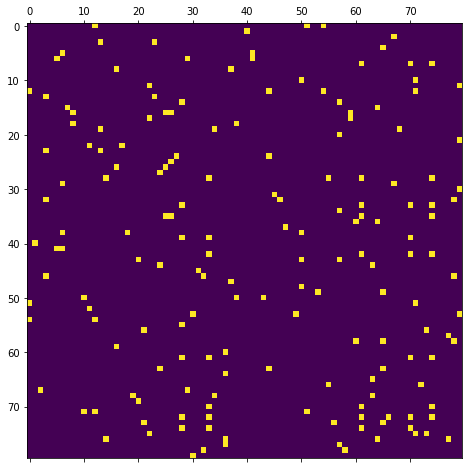

In [12]:
adj_combined = adj_curated.copy()
for labels0 in train_noisy["labels"]:
    labels0 = labels0.split(",")
    if len(labels0) > 1:
        for a, b in combinations(labels0, 2):
            ida, idb = label2index[a], label2index[b]
            adj_combined[ida, idb] += 1
            adj_combined[idb, ida] += 1
adj_combined_b = to_binary(adj_combined, 0.1)
fig = plt.figure(figsize=(8,8))
plt.matshow(adj_combined_b, fignum=0)
print(adj_combined_b.sum())
plt.show()

In [13]:
dgl_combined_b = dgl.from_scipy(csr_matrix(adj_combined_b))
dgl_combined_b = dgl_combined_b.add_self_loop()
with open("../input/combined_0.1_graph.pkl", "wb") as f:
    pickle.dump([dgl_combined_b, np.arange(80)], f)
tmp_g, tmp_indices = pickle.load(open("../input/combined_0.1_graph.pkl", "rb"))
tmp_g

Graph(num_nodes=80, num_edges=253,
      ndata_schemes={}
      edata_schemes={})

178.0


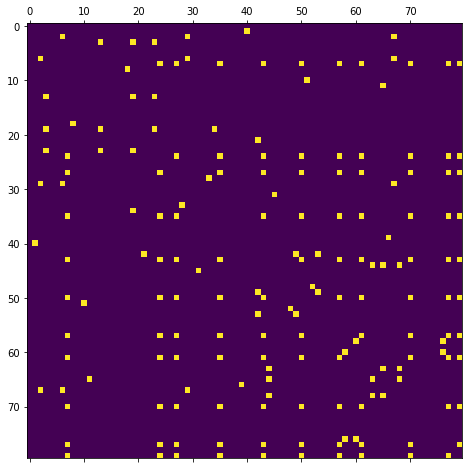

In [14]:
adj_audioset_father = np.zeros((N_labels, N_labels))
for aid, audio_info in audioset.items():
    if len(audio_info["child_ids"]) > 1:
        for i, j in combinations(audio_info["child_ids"], 2):
            audio_info1, audio_info2 = audioset[i], audioset[j]
            name1 = audio_info1["name"].replace(" ", "_")
            name2 = audio_info2["name"].replace(" ", "_")
            if name1 in label2index and name2 in label2index:
                ida, idb = label2index[name1], label2index[name2]
                adj_audioset_father[ida, idb] = 1
                adj_audioset_father[idb, ida] = 1
print(adj_audioset_father.sum())
fig = plt.figure(figsize=(8,8))
plt.matshow(adj_audioset_father, fignum=0)
plt.show()

In [15]:
dgl_audioset_father = dgl.from_scipy(csr_matrix(adj_audioset_father))
dgl_audioset_father = dgl_audioset_father.add_self_loop()
with open("../input/audioset_father_graph.pkl", "wb") as f:
    pickle.dump([dgl_audioset_father, np.arange(80)], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_father_graph.pkl", "rb"))
tmp_g

Graph(num_nodes=80, num_edges=258,
      ndata_schemes={}
      edata_schemes={})

93


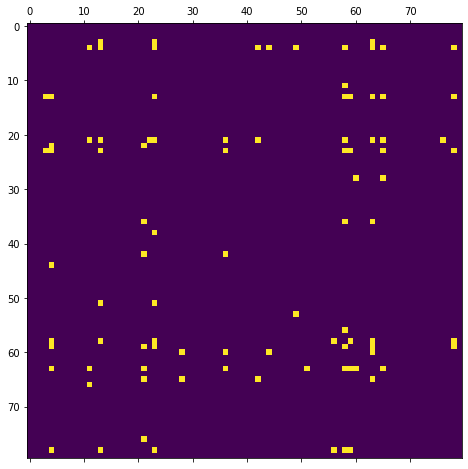

In [16]:

adj_aser = np.zeros((N_labels, N_labels))
for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    label1, label2 = audioset[aid1]["name"], audioset[aid2]["name"]
    if label1 in label2index and label2 in label2index:
        ida, idb = label2index[label1], label2index[label2]
        adj_aser[ida, idb] = np.round(rinfo["Co_Occurrence"])
adj_aser_b = (adj_aser > 0).astype(int)
np.fill_diagonal(adj_aser_b, 0)
fig = plt.figure(figsize=(8,8))
plt.matshow(adj_aser_b, fignum=0)
print(adj_aser_b.sum())
plt.show()

In [17]:
dgl_aser = dgl.from_scipy(csr_matrix(adj_aser_b))
dgl_aser = dgl_aser.add_self_loop()
with open("../input/aser_co_0.pkl", "wb") as f:
    pickle.dump([dgl_aser, np.arange(80)], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_co_0.pkl", "rb"))
tmp_g

Graph(num_nodes=80, num_edges=173,
      ndata_schemes={}
      edata_schemes={})

## type 2 graph: 632 nodes

utilizing the whole AudioSet

In [12]:
adj_audioset_all_direct = np.zeros((N_nodes, N_nodes))
adj_audioset_all_father = np.zeros((N_nodes, N_nodes))
for aid, audio_info in audioset.items():
    ida = aid2index[aid]
    for aid2 in audio_info["child_ids"]:
        idb = aid2index[aid2]
        adj_audioset_all_direct[ida, idb] = 1
        adj_audioset_all_direct[idb, ida] = 1
    if len(audio_info["child_ids"]) > 1:
        for i, j in combinations(audio_info["child_ids"], 2):
            audio_info1, audio_info2 = audioset[i], audioset[j]
            ida, idb = aid2index[i], aid2index[j]
            adj_audioset_all_father[ida, idb] = 1
            adj_audioset_all_father[idb, ida] = 1
print("direct", adj_audioset_all_direct.sum())
print("father", adj_audioset_all_father.sum())

direct 1340.0
father 5102.0


In [13]:
print(class_indices)

[416, 238, 162, 77, 86, 190, 161, 437, 232, 65, 383, 149, 376, 76, 61, 5, 512, 130, 230, 70, 453, 359, 146, 79, 426, 429, 428, 427, 518, 160, 67, 35, 4, 522, 69, 431, 49, 204, 200, 357, 237, 194, 96, 445, 423, 34, 3, 203, 480, 95, 432, 388, 483, 94, 377, 350, 57, 448, 16, 513, 28, 436, 405, 422, 54, 425, 352, 165, 424, 476, 439, 389, 520, 59, 435, 355, 17, 454, 13, 443]


In [14]:
index2alabel = {v:k for k, v in alabel2index.items()}

In [13]:
id_check = class_indices[3]
print(index2alabel[id_check])
for rel_id in np.where(adj_audioset_all_direct[id_check] == 1)[0]:
    print(index2alabel[rel_id], end="\t")
print()

Applause
Human_group_actions	


In [16]:
dgl_audioset_all_direct = dgl.from_scipy(csr_matrix(adj_audioset_all_direct))
dgl_audioset_all_direct = dgl_audioset_all_direct.add_self_loop()
# with open("../input/audioset_all_direct.pkl", "wb") as f:
#     pickle.dump([dgl_audioset_all_direct, class_indices], f)
# tmp_g, tmp_indices = pickle.load(open("../input/aser_audioset_all_direct.pkl", "rb"))
# tmp_g

In [27]:
dgl_audioset_all_father = dgl.from_scipy(csr_matrix(adj_audioset_all_father))
dgl_audioset_all_father = dgl_audioset_all_father.add_self_loop()
with open("../input/audioset_all_father.pkl", "wb") as f:
    pickle.dump([dgl_audioset_all_father, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_audioset_all_father.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=5734,
      ndata_schemes={}
      edata_schemes={})

In [15]:
adj_aser_all = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    adj_aser_all[ida, idb] = np.round(rinfo["Co_Occurrence"])
adj_aser_all_b = (adj_aser_all > 0).astype(int)
np.fill_diagonal(adj_aser_all_b, 0)
print(adj_aser_all_b.sum())

5774


In [28]:
dgl_aser_all_b = dgl.from_scipy(csr_matrix(adj_aser_all_b))
dgl_aser_all_b = dgl_aser_all_b.add_self_loop()
with open("../input/aser_all_co_0.pkl", "wb") as f:
    pickle.dump([dgl_aser_all_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_co_0.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=6406,
      ndata_schemes={}
      edata_schemes={})

In [29]:
dgl_audioset_aser_all = dgl.from_scipy(csr_matrix(adj_aser_all_b + adj_audioset_all_direct))
dgl_audioset_aser_all = dgl_audioset_aser_all.add_self_loop()
with open("../input/audioset_aser_all_co_0.pkl", "wb") as f:
    pickle.dump([dgl_audioset_aser_all, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_aser_all_co_0.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=7601,
      ndata_schemes={}
      edata_schemes={})

In [13]:
adj_aser_all_b2 = (adj_aser_all > 5).astype(int)
np.fill_diagonal(adj_aser_all_b2, 0)
print(adj_aser_all_b2.sum())

2168


In [15]:
dgl_aser_all_b2 = dgl.from_scipy(csr_matrix(adj_aser_all_b2))
dgl_aser_all_b2 = dgl_aser_all_b2.add_self_loop()
with open("../input/aser_all_co_5.pkl", "wb") as f:
    pickle.dump([dgl_aser_all_b2, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_co_5.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=2800,
      ndata_schemes={}
      edata_schemes={})

In [24]:
adj_aser_top5_b = np.zeros_like(adj_aser_all)
top_indegree_indices_per_col = adj_aser_all.argsort(0)
for j in range(N_nodes):
    top_5 = top_indegree_indices_per_col[-5:, j]
    for i in top_5:
        if adj_aser_all[i, j] > 5:
            adj_aser_top5_b[i, j] = 1
print(adj_aser_top5_b.sum())
print(pd.Series(adj_aser_top5_b.sum(0)).value_counts())

793.0
0.0    390
5.0    107
1.0     59
2.0     38
3.0     29
4.0      9
dtype: int64


In [42]:
dgl_aser_top5_b = dgl.from_scipy(csr_matrix(adj_aser_top5_b))
dgl_aser_top5_b = dgl_aser_top5_b.add_self_loop()
with open("../input/aser_all_co_5_top5.pkl", "wb") as f:
    pickle.dump([dgl_aser_top5_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_co_5_top5.pkl", "rb"))
tmp_g

/home/zhiling/.conda/envs/py36/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Graph(num_nodes=632, num_edges=1425,
      ndata_schemes={}
      edata_schemes={})

In [22]:
adj_aser_top5_b = np.zeros_like(adj_aser_all)
top_indegree_indices_per_col = adj_aser_all.argsort(0)
for j in range(N_nodes):
    top_5 = top_indegree_indices_per_col[-5:, j]
    for i in top_5:
        if adj_aser_all[i, j] > 0:
            adj_aser_top5_b[i, j] = 1
adj_aser_top5_b.sum()
print(pd.Series(adj_aser_top5_b.sum(0)).value_counts())

0.0    270
5.0    212
1.0     57
2.0     45
3.0     30
4.0     18
dtype: int64


In [49]:
dgl_aser_top5_b = dgl.from_scipy(csr_matrix(adj_aser_top5_b))
dgl_aser_top5_b = dgl_aser_top5_b.add_self_loop()
with open("../input/aser_all_co_0_top5.pkl", "wb") as f:
    pickle.dump([dgl_aser_top5_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_co_0_top5.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=2001,
      ndata_schemes={}
      edata_schemes={})

In [18]:
combined_adj = np.minimum(adj_aser_all_b2 + adj_audioset_all_direct, 1)
dgl_audioset_aser_all = dgl.from_scipy(csr_matrix(combined_adj))
dgl_audioset_aser_all = dgl_audioset_aser_all.add_self_loop()
with open("../input/audioset_aser_all_co_5.pkl", "wb") as f:
    pickle.dump([dgl_audioset_aser_all, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_aser_all_co_5.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=4055,
      ndata_schemes={}
      edata_schemes={})

dig deep into relations of ASER

In [17]:
rel_cnts = defaultdict(int)
for rid, rinfo in extracted_audioset_rels_sel.items():
    for rel_type in rinfo.keys():
        if rel_type in {"aser_clues", "name1", "name2"}:
            continue
        rel_cnts[rel_type] += 1
print(rel_cnts)

defaultdict(<class 'int'>, {'Precedence': 368, 'Co_Occurrence': 6269, 'Conjunction': 1565, 'Alternative': 4, 'Contrast': 278, 'Result': 7, 'Synchronous': 2, 'Condition': 3, 'Reason': 6, 'Succession': 6})


regard Conjunction or Precedence as high quality edges and preserve them

In [16]:
adj_conj_aser_all_b = np.zeros((N_nodes, N_nodes))
adj_pre_conj_aser_all_b = np.zeros((N_nodes, N_nodes))
adj_time_aser_all_b = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    if any(x in rinfo for x in ["Conjunction", "Precedence", "Synchronous", "Succession"]):
        adj_time_aser_all_b[ida, idb] = 1
    if "Conjunction" in rinfo or "Precedence" in rinfo:
        adj_pre_conj_aser_all_b[ida, idb] = 1
    if "Conjunction" in rinfo:
        adj_conj_aser_all_b[ida, idb] = 1
np.fill_diagonal(adj_conj_aser_all_b, 0)
np.fill_diagonal(adj_pre_conj_aser_all_b, 0)
np.fill_diagonal(adj_time_aser_all_b, 0)
print(adj_conj_aser_all_b.sum())
print(adj_pre_conj_aser_all_b.sum())
print(adj_time_aser_all_b.sum())

1398.0
1657.0
1659.0


In [17]:
adj_aser_top5_b = np.zeros_like(adj_aser_all)
top_indegree_indices_per_col = adj_aser_all.argsort(0)
for j in range(N_nodes):
    top_5 = top_indegree_indices_per_col[-5:, j]
    for i in top_5:
        if adj_time_aser_all_b[i, j] > 0:
            adj_aser_top5_b[i, j] = 1
print(adj_aser_top5_b.sum())
print(pd.Series(adj_aser_top5_b.sum(0)).value_counts())
dgl_aser_top5_b = dgl.from_scipy(csr_matrix(adj_aser_top5_b))
dgl_aser_top5_b = dgl_aser_top5_b.add_self_loop()
# with open("../input/aser_all_time_0_top5.pkl", "wb") as f:
#     pickle.dump([dgl_aser_top5_b, class_indices], f)
# tmp_g, tmp_indices = pickle.load(open("../input/aser_all_time_0_top5.pkl", "rb"))
# tmp_g

483.0
0.0    422
1.0     65
3.0     60
2.0     54
4.0     25
5.0      6
dtype: int64


In [18]:
combined_adj = np.minimum(adj_aser_top5_b + adj_audioset_all_direct, 1)
dgl_combined_aser_time_0_top5 = dgl.from_scipy(csr_matrix(combined_adj))
dgl_combined_aser_time_0_top5 = dgl_combined_aser_time_0_top5.add_self_loop()
with open(f"../input/audioset_aser_time_0_top5.pkl", "wb") as f:
    pickle.dump([dgl_combined_aser_time_0_top5, class_indices], f)
tmp_g, tmp_indices = pickle.load(open(f"../input/audioset_aser_time_0_top5.pkl", "rb"))
tmp_g

/home/zhiling/.conda/envs/py36/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Graph(num_nodes=632, num_edges=2413,
      ndata_schemes={}
      edata_schemes={})

In [14]:
dgl_conj_aser_all_b = dgl.from_scipy(csr_matrix(adj_conj_aser_all_b))
dgl_conj_aser_all_b = dgl_conj_aser_all_b.add_self_loop()
with open("../input/aser_all_conj_0.pkl", "wb") as f:
    pickle.dump([dgl_conj_aser_all_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_conj_0.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=2030,
      ndata_schemes={}
      edata_schemes={})

In [15]:
dgl_pre_conj_aser_all_b = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b = dgl_pre_conj_aser_all_b.add_self_loop()
with open("../input/aser_all_pre_conj_0.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_pre_conj_0.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=2289,
      ndata_schemes={}
      edata_schemes={})

In [25]:
rinfo

{'aser_clues': [['e139c6496188682e17f56f05258150afe379ca4b',
   'e139c6496188682e17f56f05258150afe379ca4b']],
 'name1': 'Zing',
 'name2': 'Zing',
 'Co_Occurrence': 4.0}

In [32]:
thresold = 1
adj_pre_conj_aser_all_thr = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    if "Conjunction" in rinfo or "Precedence" in rinfo:
        # adj_pre_conj_aser_all_thr[ida, idb] += 1
        adj_pre_conj_aser_all_thr[ida, idb] += np.ceil(rinfo.get("Conjunction", 0))
        adj_pre_conj_aser_all_thr[ida, idb] += np.ceil(rinfo.get("Precedence", 0))
np.fill_diagonal(adj_pre_conj_aser_all_thr, 0)
adj_pre_conj_aser_all_thr = (adj_pre_conj_aser_all_thr > thresold).astype(int)
print(adj_pre_conj_aser_all_thr.sum())

736


In [33]:
dgl_pre_conj_aser_all_thr = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_thr))
dgl_pre_conj_aser_all_thr = dgl_pre_conj_aser_all_thr.add_self_loop()
with open(f"../input/aser_all_pre_conj_{thresold}.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_thr, class_indices], f)
tmp_g, tmp_indices = pickle.load(open(f"../input/aser_all_pre_conj_{thresold}.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=1368,
      ndata_schemes={}
      edata_schemes={})

In [35]:
combined_adj = np.minimum(adj_pre_conj_aser_all_thr + adj_audioset_all_direct, 1)
dgl_combined_pre_conj_aser_all_thr = dgl.from_scipy(csr_matrix(combined_adj))
dgl_combined_pre_conj_aser_all_thr = dgl_pre_conj_aser_all_thr.add_self_loop()
with open(f"../input/audioset_aser_all_pre_conj_{thresold}.pkl", "wb") as f:
    pickle.dump([dgl_combined_pre_conj_aser_all_thr, class_indices], f)
tmp_g, tmp_indices = pickle.load(open(f"../input/audioset_aser_all_pre_conj_{thresold}.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=2000,
      ndata_schemes={}
      edata_schemes={})

In [17]:
# multiple single relations
single_rel_types = {"Precedence": 'pre', "Conjunction": 'conj', "Contrast": 'contrast', "Co_Occurrence": 'co'}

rel2adj = {rel: np.zeros((N_nodes, N_nodes), dtype=int) for rel in single_rel_types}

for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    for cand_rel in single_rel_types:
        if cand_rel in rinfo:
            rel2adj[cand_rel][ida, idb] = 1

for rel, adj in rel2adj.items():
    rel_abbr = single_rel_types[rel]
    print(rel, adj.sum())
    if adj.sum() <= 0:
        continue
    adj = np.minimum(adj + adj_audioset_all_direct, 1)
    dgl_g = dgl.from_scipy(csr_matrix(adj))
    dgl_g = dgl_g.add_self_loop()

    with open(f"../input/audioset_aser_all_{rel_abbr}_0.pkl", "wb") as f:
        pickle.dump([dgl_g, class_indices], f)

Precedence 358
Conjunction 1527
Contrast 270
Co_Occurrence 6044


In [15]:
# multiple single relations
single_rel_types = {"Precedence": 'pre', "Conjunction": 'conj', "Contrast": 'contrast', "Co_Occurrence": 'co'}

rel2adj = {rel: np.zeros((N_nodes, N_nodes), dtype=int) for rel in single_rel_types}

for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    for cand_rel in single_rel_types:
        if cand_rel in rinfo:
            rel2adj[cand_rel][ida, idb] = 1
            rel2adj[cand_rel][idb, ida] = 1

for rel, adj in rel2adj.items():
    rel_abbr = single_rel_types[rel]
    print(rel, adj.sum())
    if adj.sum() <= 0:
        continue
    adj = np.minimum(adj + adj_audioset_all_direct, 1)
    dgl_g = dgl.from_scipy(csr_matrix(adj))
    dgl_g = dgl_g.add_self_loop()

    with open(f"../input/audioset_aser_all_{rel_abbr}_0_bidi.pkl", "wb") as f:
        pickle.dump([dgl_g, class_indices], f)

Precedence 640
Conjunction 2597
Contrast 510
Co_Occurrence 8832


In [14]:
# multiple single relations with threshold
single_rel_types = {"Precedence": 'pre', "Conjunction": 'conj', "Contrast": 'contrast', "Co_Occurrence": 'co'}

rel2adj = {rel: np.zeros((N_nodes, N_nodes), dtype=int) for rel in single_rel_types}

for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    for cand_rel in single_rel_types:
        if cand_rel in rinfo:
            rel2adj[cand_rel][ida, idb] += np.round(rinfo[cand_rel])

threshold = 1
for rel, adj in rel2adj.items():
    rel_abbr = single_rel_types[rel]
    adj = (adj > threshold).astype(int)
    print(rel, adj.sum())
    if adj.sum() <= 0:
        continue
    adj = np.minimum(adj + adj_audioset_all_direct, 1)
    dgl_g = dgl.from_scipy(csr_matrix(adj))
    dgl_g = dgl_g.add_self_loop()

    with open(f"../input/audioset_aser_all_{rel_abbr}_{threshold}.pkl", "wb") as f:
        pickle.dump([dgl_g, class_indices], f)

Precedence 154
Conjunction 709
Contrast 131
Co_Occurrence 6044


## relational combine

In [33]:
dgl_audioset_all_direct = dgl.from_scipy(csr_matrix(adj_audioset_all_direct))
dgl_audioset_all_direct = dgl_audioset_all_direct.add_self_loop()
begs1, ends1 = dgl_audioset_all_direct.edges()
etypes1 = torch.zeros_like(begs1)
dgl_pre_conj_aser_all_b = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b = dgl_pre_conj_aser_all_b.add_self_loop()
begs2, ends2 = dgl_pre_conj_aser_all_b.edges()
etypes2 = torch.ones_like(begs2)
dgl_rel_combine_audioset_pre_conj_aser = dgl.graph((torch.cat([begs1, begs2]), torch.cat([ends1, ends2])))
dgl_rel_combine_audioset_pre_conj_aser.edata["etype"] = torch.cat([etypes1, etypes2])
dgl_rel_combine_audioset_pre_conj_aser

Graph(num_nodes=632, num_edges=4261,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

In [34]:
dgl_rel_combine_audioset_pre_conj_aser.edata["etype"].shape

torch.Size([4261])

In [35]:
with open("../input/audioset_aser_rel_combine_pre_conj_0.pkl", "wb") as f:
    pickle.dump([dgl_rel_combine_audioset_pre_conj_aser, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_aser_rel_combine_pre_conj_0.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=4261,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

only set self-loop for AudioSet, using the original self relations in ASER

In [12]:
adj_pre_conj_aser_all_b = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_sel.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    if "Conjunction" in rinfo or "Precedence" in rinfo:
        adj_pre_conj_aser_all_b[ida, idb] = 1

dgl_audioset_all_direct = dgl.from_scipy(csr_matrix(adj_audioset_all_direct))
dgl_audioset_all_direct = dgl_audioset_all_direct.add_self_loop()
begs1, ends1 = dgl_audioset_all_direct.edges()
etypes1 = torch.zeros_like(begs1)
dgl_pre_conj_aser_all_b2 = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
# dgl_pre_conj_aser_all_b = dgl_pre_conj_aser_all_b.add_self_loop()
begs2, ends2 = dgl_pre_conj_aser_all_b2.edges()
etypes2 = torch.ones_like(begs2)
dgl_rel_combine_audioset_pre_conj_aser2 = dgl.graph((torch.cat([begs1, begs2]), torch.cat([ends1, ends2])))
dgl_rel_combine_audioset_pre_conj_aser2.edata["etype"] = torch.cat([etypes1, etypes2])
dgl_rel_combine_audioset_pre_conj_aser2

Graph(num_nodes=632, num_edges=3768,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

In [41]:
with open("../input/audioset_aser_rel_combine_pre_conj_0_2.pkl", "wb") as f:
    pickle.dump([dgl_rel_combine_audioset_pre_conj_aser2, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_aser_rel_combine_pre_conj_0_2.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=3768,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

In [14]:
adj_pre_conj_aser_all_b3 = adj_pre_conj_aser_all_b.copy()
np.fill_diagonal(adj_pre_conj_aser_all_b3, 0)
dgl_pre_conj_aser_all_b3 = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b3))
begs2, ends2 = dgl_pre_conj_aser_all_b3.edges()
etypes2 = torch.ones_like(begs2)
dgl_rel_combine_audioset_pre_conj_aser3 = dgl.graph((torch.cat([begs1, begs2]), torch.cat([ends1, ends2])))
dgl_rel_combine_audioset_pre_conj_aser3.edata["etype"] = torch.cat([etypes1, etypes2])
dgl_rel_combine_audioset_pre_conj_aser3

Graph(num_nodes=632, num_edges=3629,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

In [15]:
with open("../input/audioset_aser_rel_combine_pre_conj_0_3.pkl", "wb") as f:
    pickle.dump([dgl_rel_combine_audioset_pre_conj_aser3, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/audioset_aser_rel_combine_pre_conj_0_3.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=3629,
      ndata_schemes={}
      edata_schemes={'etype': Scheme(shape=(), dtype=torch.int64)})

## Noisy ASER graph

In [12]:
adj_pre_conj_aser_all_b = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_v2.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    if "Conjunction" in rinfo or "Precedence" in rinfo:
        adj_pre_conj_aser_all_b[ida, idb] = 1
np.fill_diagonal(adj_pre_conj_aser_all_b, 0)
print(adj_pre_conj_aser_all_b.sum())

399.0


In [14]:
dgl_pre_conj_aser_all_b = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b = dgl_pre_conj_aser_all_b.add_self_loop()
with open("../input/aser_all_pre_conj_0_v2noisy.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_pre_conj_0_v2noisy.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=1031,
      ndata_schemes={}
      edata_schemes={})

In [14]:
adj_pre_conj_aser_all_b = np.maximum(0, adj_pre_conj_aser_all_b - adj_audioset_all_direct)
dgl_pre_conj_aser_all_b_no_onto = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b_no_onto = dgl_pre_conj_aser_all_b_no_onto.add_self_loop()
with open("../input/aser_all_pre_conj_0_v2noisy_no_onto.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_b_no_onto, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_pre_conj_0_v2noisy_no_onto.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=1008,
      ndata_schemes={}
      edata_schemes={})

In [15]:
adj_pre_conj_aser_all_b = np.zeros((N_nodes, N_nodes))
for rid, rinfo in extracted_audioset_rels_v3.items():
    aid1, aid2 = rid.split("-")
    aid1 = aid1[:-2] if aid1[-2] == "~" else aid1
    aid2 = aid2[:-2] if aid2[-2] == "~" else aid2
    ida, idb = aid2index[aid1], aid2index[aid2]
    if "Conjunction" in rinfo or "Precedence" in rinfo:
        adj_pre_conj_aser_all_b[ida, idb] = 1
np.fill_diagonal(adj_pre_conj_aser_all_b, 0)
print(adj_pre_conj_aser_all_b.sum())

8655.0


In [16]:
dgl_pre_conj_aser_all_b = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b = dgl_pre_conj_aser_all_b.add_self_loop()
with open("../input/aser_all_pre_conj_0_v3noisy.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_b, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_pre_conj_0_v3noisy.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=9287,
      ndata_schemes={}
      edata_schemes={})

In [16]:
adj_pre_conj_aser_all_b = np.maximum(0, adj_pre_conj_aser_all_b - adj_audioset_all_direct)
dgl_pre_conj_aser_all_b_no_onto = dgl.from_scipy(csr_matrix(adj_pre_conj_aser_all_b))
dgl_pre_conj_aser_all_b_no_onto = dgl_pre_conj_aser_all_b_no_onto.add_self_loop()
with open("../input/aser_all_pre_conj_0_v3noisy_no_onto.pkl", "wb") as f:
    pickle.dump([dgl_pre_conj_aser_all_b_no_onto, class_indices], f)
tmp_g, tmp_indices = pickle.load(open("../input/aser_all_pre_conj_0_v3noisy_no_onto.pkl", "rb"))
tmp_g

Graph(num_nodes=632, num_edges=9145,
      ndata_schemes={}
      edata_schemes={})

### align PANNs label

In [19]:
ids_set_panns = pd.read_csv("/home/zhiling/py3_workspace/audioset_tagging_cnn/metadata/class_labels_indices.csv", header=0, index_col=0)["mid"]
# print(ids_set_panns)
class_indices_panns = [aid2index[id0] for id0 in ids_set_panns]
# print(class_indices_panns)

In [20]:
dcase2019_to_panns = [class_indices_panns.index(i) for i in class_indices]
print(dcase2019_to_panns)

[353, 209, 143, 67, 75, 168, 142, 372, 203, 58, 321, 130, 314, 66, 54, 3, 442, 113, 201, 63, 386, 299, 127, 69, 362, 365, 364, 363, 448, 141, 60, 33, 2, 452, 62, 367, 44, 181, 177, 297, 208, 172, 84, 379, 359, 32, 1, 180, 412, 83, 368, 326, 415, 82, 315, 290, 51, 381, 14, 443, 26, 371, 342, 358, 49, 361, 292, 146, 360, 408, 374, 327, 450, 53, 370, 295, 15, 387, 11, 378]


In [21]:
in_dir = '/home/zhiling/py3_workspace/freesound-audio-tagging-2019/input/'
out_dir = "/home/zhiling/py3_workspace/audioset_tagging_cnn/resources/"
# transfer_list = ["audioset_aser_all_pre_conj_0.pkl", 'aser_all_pre_conj_0.pkl', 'audioset_all_direct.pkl', 'audioset_aser_rel_combine_pre_conj_0_2.pkl']
# transfer_list = ["audioset_aser_all_pre_conj_1.pkl", 'aser_all_pre_conj_1.pkl']
# transfer_list = ["aser_all_co_5.pkl", "audioset_aser_all_co_5.pkl"]
# transfer_list = [f"audioset_aser_all_{rel}_0.pkl" for rel in {"pre", "conj", "contrast", "co"}]
# transfer_list = [f"audioset_aser_all_{rel}_0_bidi.pkl" for rel in {"pre", "conj", "contrast", "co"}]
# transfer_list = [f"audioset_aser_all_{rel}_1.pkl" for rel in {"pre", "conj", "contrast", "co"}]
# transfer_list = ['aser_all_co_0_top5.pkl', 'aser_all_co_5_top5.pkl', 'aser_all_time_0_top5.pkl']
transfer_list = ['audioset_aser_time_0_top5.pkl']
for graph_name in transfer_list:
    with open(in_dir+graph_name, "rb") as fi, open(out_dir+graph_name, "wb") as fo:
        g, _ = pickle.load(fi)
        print(graph_name, g)
        pickle.dump([g, class_indices_panns], fo)

audioset_aser_time_0_top5.pkl Graph(num_nodes=632, num_edges=2413,
      ndata_schemes={}
      edata_schemes={})
